In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt

In [2]:
#choose to run with colab, run the following code in advance
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Mounted at /content/drive


**LOGREG ref:**

https://github.com/yawen-d/Logistic-Regression-on-MNIST-with-NumPy-from-Scratch

https://towardsdatascience.com/softmax-regression-in-python-multi-class-classification-3cb560d90cb2

Cyclical Learning Rates for Training Neural Networks Leslie N. Smith
https://arxiv.org/abs/1506.01186 

In [3]:
def get_detaset():
    train_df = pd.read_csv('classification-of-mnist-digits/train.csv')
    train = train_df.to_numpy()
    test_df = pd.read_csv('classification-of-mnist-digits/test.csv')
    test = test_df.to_numpy()
    train_result_df = pd.read_csv('classification-of-mnist-digits/train_result.csv')
    train_result = train_result_df.to_numpy()
    return train, test, train_result

def split_testset(data):
    data = np.delete(data, -1, axis=1)
    #z-score standardization
    standardize_data = (data-np.mean(data, axis=1)[:,np.newaxis])/np.std(data, axis=1)[:,np.newaxis]
    return standardize_data

def treat_dataset(data, data_result):
    data = np.delete(data, -1, axis=1)
    #z-score standardization
    standardize_data = (data-np.mean(data, axis=1)[:,np.newaxis])/np.std(data, axis=1)[:,np.newaxis]
    data_result = np.delete(data_result, 0, axis=1)
    indexes = np.arange(standardize_data.shape[0])
    train_indexes = np.concatenate((indexes[indexes%5 == 0],indexes[indexes%5 == 1],indexes[indexes%5 == 2],indexes[indexes%5 == 3]),axis=0)
    test_indexes = indexes[indexes%5==4]
    return standardize_data[train_indexes,:],standardize_data[test_indexes,:],data_result[train_indexes,:].flatten(),data_result[test_indexes,:].flatten()

In [5]:
def one_hot(y, c):  
    # y--> label/ground truth.
    # c--> Number of classes.
    
    # A zero matrix of size (m, c)
    y_hot = np.zeros((len(y), c))
    
    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    #print(np.arange(len(y)))
    #print(y)
    y_hot[np.arange(len(y)), y] = 1
    
    return y_hot

def softmax(z):
    
    # z--> linear part.
    
    # subtracting the max of z for numerical stability.
    exp = np.exp(z - np.max(z))
    
    # Calculating softmax for all examples.
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
        
    return exp

def predict(X, w, b):
    
    # X --> Input.
    # w --> weights.
    # b --> bias.
    
    # Predicting
    z = X@w + b
    y_hat = softmax(z)
    
    # Returning the class with highest probability.
    return np.argmax(y_hat, axis=1)

def accuracy(y, y_hat):
    return np.sum(y==y_hat)/len(y)

def fit_1(X, y, X_valid, y_valid, lr, c, epochs, batch_size, early_stop, f_print):
    '''
    # X         --> training dataset.
    # y         --> training label.
    # X_valid   --> validation dataset
    # y_valid   --> validation label
    # lr        --> Learning rate.
    # c         --> Number of classes. in our case = 19
    # epochs    --> Number of iterations max. 
    # batch_size--> Number of data in one mini_batch. 
    # early_stop--> Number of epoch needed to trigger autostop.
    # f_print   --> Print frequency
    '''
        
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    
    # Initializing weights and bias randomly.#归一化***
    w = np.random.random((n, c))/np.sqrt(n*c)
    b = np.random.random(c)/np.sqrt(c)

    # Empty list to store losses.
    losses, accuracys = [], []
    # Empty list to store accuracy.
    losses_valid, accuracys_valid = [], []
    # Initializing best accuracys
    best_acc = 0
    
    # Initializing learning rate
    lr_t = lr
    #Shuffle X,y
    p = np.random.permutation(X.shape[0])
    X_r = X[p]
    y_r = y[p]
    
    # Mini-batch not random(not use)
    '''
    x_batches = np.zeros(((int(X_r.shape[0]/batch_size), batch_size, 28*56)))
    y_batches = np.zeros(((int(X_r.shape[0]/batch_size), batch_size)))
    batch_num = int(X_r.shape[0]/batch_size)
    for i in range(0, X_r.shape[0], batch_size):
        x_batches[int(i/batch_size)] = X_r[i:i + batch_size]
        y_batches[int(i/batch_size)] = y_r[i:i + batch_size]
    '''

    #We may try different lr_initial in lr_test
    '''
    lr_test = np.logspace(-5, 2, num=50, endpoint=True, dtype=None)
    '''
    print('Start training...')
    # Training loop.
    for epoch in range(epochs):
        #in lr_test
        '''
        lr_t = lr_test[epoch] #lr_test
        '''
        #lr_t fix
        lr_t = lr

        #A: Reduce the lr_t when satisfait conditions
        '''
        try:
            if accuracys_test[-1] - accuracys_test[-2] < 0.0005:
                lr_t = lr_t * 0.5
        except:
            pass
        '''

        #B: Deduce the lr_t periodically
        '''
        if epoch%10 == 0 and epoch != 0:
            lr_t = lr_t / 2
        '''
    
        # Mini-batch ramdom every epoch
        rand_indices = np.random.choice(X.shape[0],X.shape[0],replace=False)
        batch_num = int(X.shape[0]/batch_size)
        
        for i in range(batch_num):
            index = rand_indices[batch_size*i:batch_size*(i+1)]
            x_batch = X[index]
            y_batch = y[index]
            #x_batch, y_batch = x_batches[i], y_batches[i].astype(int)
            
            # Calculating hypothesis/prediction.(mini-batch)
            z_batch = x_batch@w + b
            y_hat = softmax(z_batch)
        
            # One-hot encoding y.
            y_hot = one_hot(y_batch, c)
        
            # Calculating the gradient of loss w.r.t w and b.
            w_grad = (1/m)*np.dot(x_batch.T, (y_hat - y_hot)) 
            b_grad = (1/m)*np.sum(y_hat - y_hot)
        
            # Updating the parameters.
            w = w - lr_t*w_grad
            b = b - lr_t*b_grad
        
        #(TRAIN) Calculating loss and accuracy, appending it in the list.
        z = X@w + b
        y_hat = softmax(z)
        loss = -np.mean(np.log(y_hat[np.arange(len(y)), y]))
        losses.append(loss)

        pre = np.argmax(y_hat, axis=1)
        acc = np.sum(y==pre)/len(y)
        accuracys.append(acc)
            
        #(VALIDATION) Calculating loss and accuracy, appending it in the list.
        z_valid = X_valid@w + b
        y_hat_valid = softmax(z_valid)
        loss_valid = -np.mean(np.log(y_hat_valid[np.arange(len(y_valid)), y_valid]))
        losses_valid.append(loss_valid)

        pre_valid = np.argmax(y_hat_valid, axis=1)
        acc_valid = np.sum(y_valid==pre_valid)/len(y_valid)
        accuracys_valid.append(acc_valid)

        # Printing out the loss at Accuracy every 10th iteration.
        if epoch%f_print==0:
            print('Epoch {epoch}==> Loss = {loss} AND Accuracy = {acc} AND lr = {lr}'
                  .format(epoch=epoch, loss=losses_valid[-1], acc=accuracys_valid[-1], lr = lr_t))
            
        # Early stop acc_temp
        if accuracys_valid[-1] > best_acc:
            best_acc = accuracys_valid[-1]
            es = 0 #reset 
        es = es + 1
        if es == early_stop:
            break

            
    return w, b, losses_valid, accuracys_valid, epoch

In [6]:
#Save weight and bias as . json, and they can be read

def save_json(w, b, path):
    wlist = w.tolist()
    blist = b.tolist()
    wb = {'weight':wlist, 'bias':blist}
    json_str = json.dumps(wb, indent=4)
    with open(path+'.json', 'w') as f:  # 创建一个params.json文件
        f.write(json_str) 
    pass

def load_json(path):
    with open(path+'.json', 'r') as f:
        wb_dict = json.load(f)
    w = wb_dict['weight']
    b = wb_dict['bias']
    return np.array(w), np.array(b)

In [7]:
train, test, train_result = get_detaset()
test_data = split_testset(test)
X_train, X_valid, y_train, y_valid = treat_dataset(train, train_result)
X_train_r = X_train.reshape(40000,28*56)
X_valid_r = X_valid.reshape(10000,28*56)

**Try Cyclical Learning Rates** \\
For CNN in general, I tried for logreg in here

In [25]:
lr_test = np.logspace(-5, 2, num=50, endpoint=True, dtype=None)
print(lr_test)

[1.00000000e-05 1.38949549e-05 1.93069773e-05 2.68269580e-05
 3.72759372e-05 5.17947468e-05 7.19685673e-05 1.00000000e-04
 1.38949549e-04 1.93069773e-04 2.68269580e-04 3.72759372e-04
 5.17947468e-04 7.19685673e-04 1.00000000e-03 1.38949549e-03
 1.93069773e-03 2.68269580e-03 3.72759372e-03 5.17947468e-03
 7.19685673e-03 1.00000000e-02 1.38949549e-02 1.93069773e-02
 2.68269580e-02 3.72759372e-02 5.17947468e-02 7.19685673e-02
 1.00000000e-01 1.38949549e-01 1.93069773e-01 2.68269580e-01
 3.72759372e-01 5.17947468e-01 7.19685673e-01 1.00000000e+00
 1.38949549e+00 1.93069773e+00 2.68269580e+00 3.72759372e+00
 5.17947468e+00 7.19685673e+00 1.00000000e+01 1.38949549e+01
 1.93069773e+01 2.68269580e+01 3.72759372e+01 5.17947468e+01
 7.19685673e+01 1.00000000e+02]


Start training...
Epoch 0==> Loss = 2.958354722117131 AND Accuracy = 0.0489 AND lr = 1e-05
Epoch 10==> Loss = 2.951030788449213 AND Accuracy = 0.0549 AND lr = 0.00026826957952797245
Epoch 20==> Loss = 2.829956651875627 AND Accuracy = 0.1012 AND lr = 0.007196856730011514
Epoch 30==> Loss = 2.5197599391800685 AND Accuracy = 0.1682 AND lr = 0.19306977288832497
Epoch 40==> Loss = 2.27232280678833 AND Accuracy = 0.2081 AND lr = 5.179474679231202


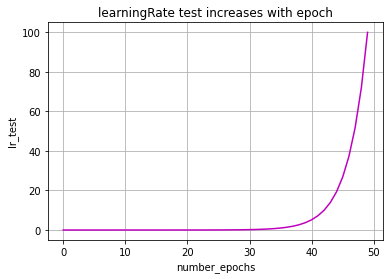

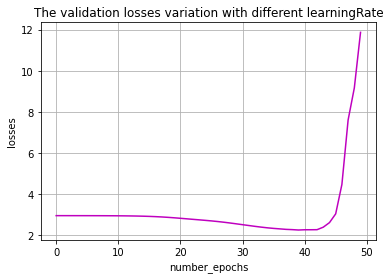

In [17]:
'''
########################################################################################
######## Don't run, running lr_test need <manually changing> code in func fit_1 ########
########################################################################################
#Try Cyclical Learning Rates to find best lr for model.

#lr_test = np.logspace(-5, 2, num=50, endpoint=True, dtype=None)
and
#lr_t = lr_test[epoch] #lr_test
'''
# Try lr_test
np.random.seed(1997)
w, b, losses_lr_test, accuracys_lr_test, epoch = fit_1(X_train_r, y_train, X_valid_r, y_valid, 
                                                 lr=0.1, c=19, epochs=50, batch_size=100, early_stop=100, f_print=10)

plt.title('learningRate test increases with epoch')
plt.xlabel('number_epochs')
plt.ylabel('lr_test')
plt.plot(lr_test,'m')
plt.grid()
plt.show()

plt.title('The validation losses variation with different learningRate')
plt.xlabel('number_epochs')
plt.ylabel('losses')
plt.plot(losses_lr_test,'m')
plt.grid()
plt.show()


We can estimate that the lr around 40epoch is optimal, corresponding to a learning rate of 3. To be honest this is generally too high. But the training results of trying to use lr=3 are very good, and the accuracy exceeds 0.2 in 1 epoch. 

Start training...
Epoch 0==> Loss = 2.3651671266299825 AND Accuracy = 0.1964 AND lr = 3
Epoch 1==> Loss = 2.3102970913043 AND Accuracy = 0.2101 AND lr = 3
Epoch 2==> Loss = 2.295615047452724 AND Accuracy = 0.2057 AND lr = 3
Epoch 3==> Loss = 2.2657299123570356 AND Accuracy = 0.2159 AND lr = 3
Epoch 4==> Loss = 2.2622959364259625 AND Accuracy = 0.214 AND lr = 3
Epoch 5==> Loss = 2.248838422910194 AND Accuracy = 0.2188 AND lr = 3
Epoch 6==> Loss = 2.2495074416329754 AND Accuracy = 0.214 AND lr = 3
Epoch 7==> Loss = 2.2471054029024495 AND Accuracy = 0.2177 AND lr = 3


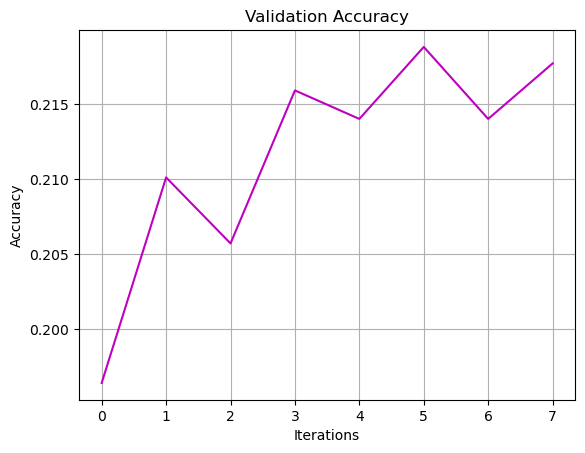

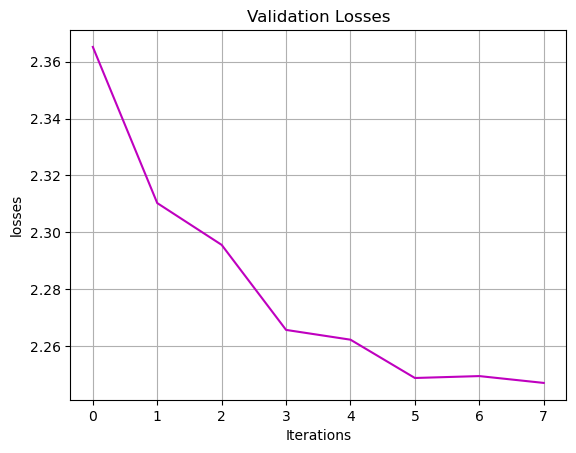

In [8]:
# Training lr=3 no lr reduce
np.random.seed(1997)
w, b, losses_test, accuracys_test, epoch = fit_1(X_train_r, y_train, X_valid_r, y_valid, 
                                                 lr=3, c=19, epochs=100, batch_size=100, early_stop=3, f_print=1)
plt.title('Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(accuracys_test,'m')
plt.grid()
plt.show()

plt.title('Validation Losses')
plt.xlabel('Iterations')
plt.ylabel('losses')
plt.plot(losses_test,'m')
plt.grid()
plt.show()

In [53]:
save_json(w, b, 'logreg3')
w1, b1 = load_json('logreg3')
valid_preds = predict(X_valid_r, w1, b1)
accuracy(y_valid, valid_preds)

0.2177

Start training...
Epoch 0==> Loss = 2.7263835636776843 AND Accuracy = 0.123 AND lr = 0.1
Epoch 5==> Loss = 2.536673833878852 AND Accuracy = 0.1644 AND lr = 0.1
Epoch 10==> Loss = 2.460580587140124 AND Accuracy = 0.1828 AND lr = 0.1
Epoch 15==> Loss = 2.4166400523706177 AND Accuracy = 0.1907 AND lr = 0.1
Epoch 20==> Loss = 2.38707318636157 AND Accuracy = 0.1987 AND lr = 0.1
Epoch 25==> Loss = 2.3651094303595337 AND Accuracy = 0.1995 AND lr = 0.1
Epoch 30==> Loss = 2.348603289726903 AND Accuracy = 0.1993 AND lr = 0.1
Epoch 35==> Loss = 2.3348326177379213 AND Accuracy = 0.2055 AND lr = 0.1
Epoch 40==> Loss = 2.3235418789664997 AND Accuracy = 0.206 AND lr = 0.1


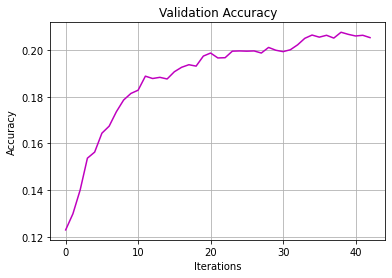

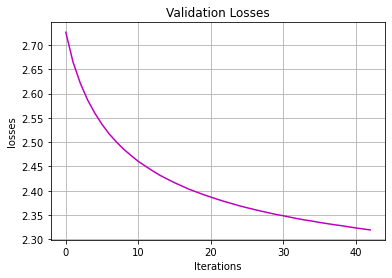

In [54]:
# Training lr=0.1 no lr reduce
np.random.seed(1997)
w, b, losses_test, accuracys_test, epoch = fit_1(X_train_r, y_train, X_valid_r, y_valid, 
                                                 lr=0.1, c=19, epochs=100, batch_size=100, early_stop=5, f_print=5)
plt.title('Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(accuracys_test,'m')
plt.grid()
plt.show()

plt.title('Validation Losses')
plt.xlabel('Iterations')
plt.ylabel('losses')
plt.plot(losses_test,'m')
plt.grid()
plt.show()

In [55]:
save_json(w, b, 'logreg0.1')
w1, b1 = load_json('logreg0.1')
valid_preds = predict(X_valid_r, w1, b1)
accuracy(y_valid, valid_preds)

0.2053

Start training...
Epoch 0==> Loss = 2.8923453958829852 AND Accuracy = 0.0914 AND lr = 0.01
Epoch 10==> Loss = 2.718698803837093 AND Accuracy = 0.1232 AND lr = 0.01
Epoch 20==> Loss = 2.659777026534479 AND Accuracy = 0.1312 AND lr = 0.01
Epoch 30==> Loss = 2.6173696949031466 AND Accuracy = 0.1419 AND lr = 0.01
Epoch 40==> Loss = 2.584104341761504 AND Accuracy = 0.1524 AND lr = 0.01
Epoch 50==> Loss = 2.557029454748329 AND Accuracy = 0.1599 AND lr = 0.01
Epoch 60==> Loss = 2.5344528680518956 AND Accuracy = 0.164 AND lr = 0.01
Epoch 70==> Loss = 2.515221053382044 AND Accuracy = 0.1694 AND lr = 0.01
Epoch 80==> Loss = 2.498596259612155 AND Accuracy = 0.174 AND lr = 0.01
Epoch 90==> Loss = 2.4840202323768636 AND Accuracy = 0.177 AND lr = 0.01


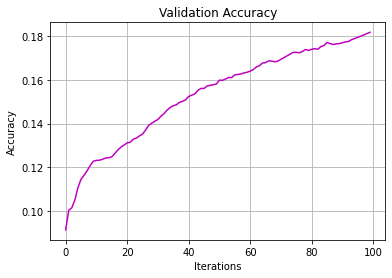

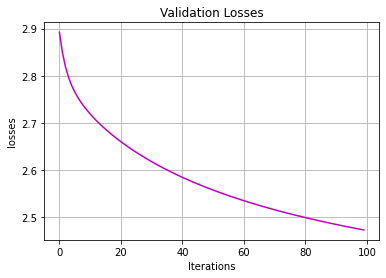

In [56]:
# Training lr=0.01 no lr reduce
np.random.seed(1997)
w, b, losses_test, accuracys_test, epoch = fit_1(X_train_r, y_train, X_valid_r, y_valid, 
                                                 lr=0.01, c=19, epochs=100, batch_size=100, early_stop=8, f_print=10)
plt.title('Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(accuracys_test,'m')
plt.grid()
plt.show()

plt.title('Validation Losses')
plt.xlabel('Iterations')
plt.ylabel('losses')
plt.plot(losses_test,'m')
plt.grid()
plt.show()

In [57]:
save_json(w, b, 'logreg0.01')
w1, b1 = load_json('logreg0.01')
valid_preds = predict(X_valid_r, w1, b1)
accuracy(y_valid, valid_preds)

0.1818

In [ ]:

test_preds = predict(test_data, w, b)
df_submit = pd.DataFrame(test_preds, columns = ['Class'])
# get csv submission
df_submit=df_submit.reset_index()
df_submit.rename(columns = {'index':'Index'}, inplace = True)
df_submit.to_csv('./logReglr=3.csv', index = False)